In [1]:
# -*- coding: utf-8 -*- 

import os
import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib
import nilearn as nil

from bids import BIDSLayout
from tqdm import tqdm

import pickle
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import zscore

from nltools.external import glover_hrf

import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# information for path, hyperparams..
cfg = {
    'data_dir': Path('/home/mybirth0407/datasets/ds000005')
}

In [3]:
layout = BIDSLayout(cfg['data_dir'], derivatives=True)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [4]:
layout

BIDS Layout: .../mybirth0407/datasets/ds000005 | Subjects: 16 | Sessions: 0 | Runs: 48

In [5]:
fmri_filepaths = layout.derivatives['fMRIPrep'].get(
                    subject=layout.get(target='subject', return_type='id')[0],
                    return_type='file',
                    suffix='bold',
                    extension='nii.gz')


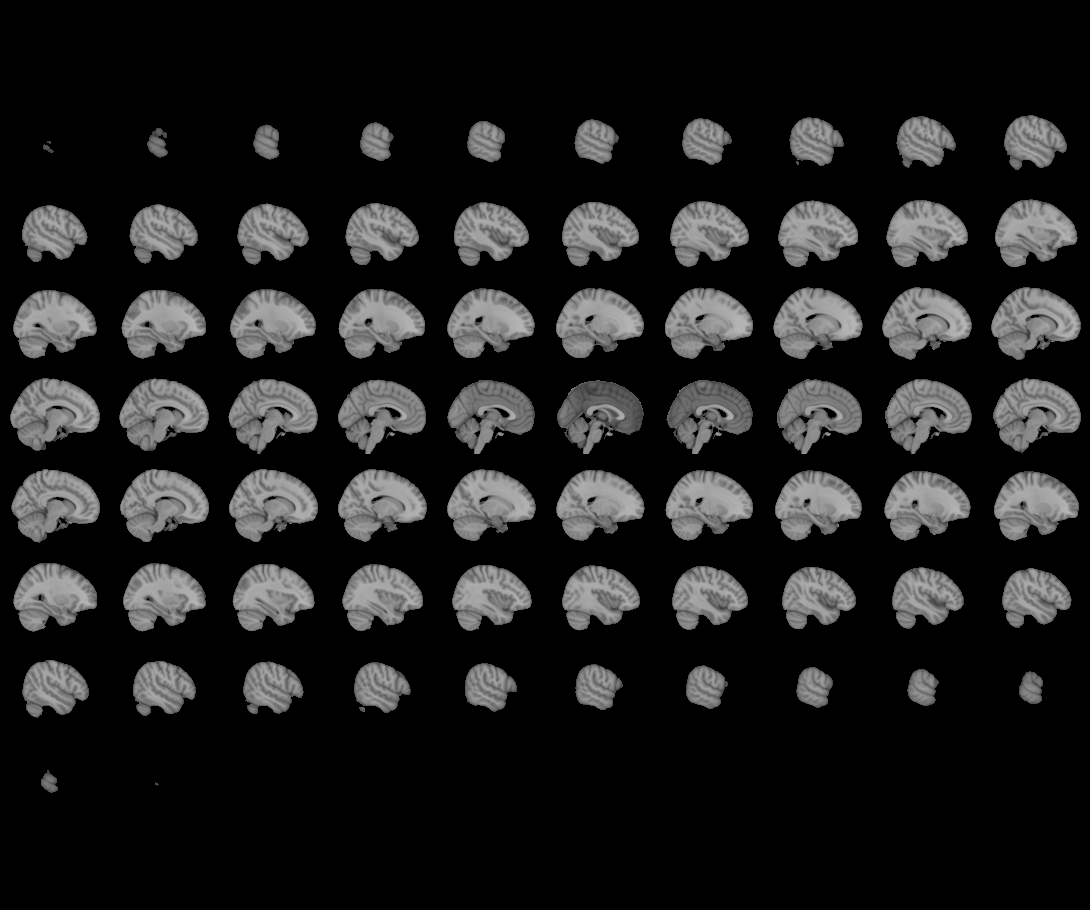
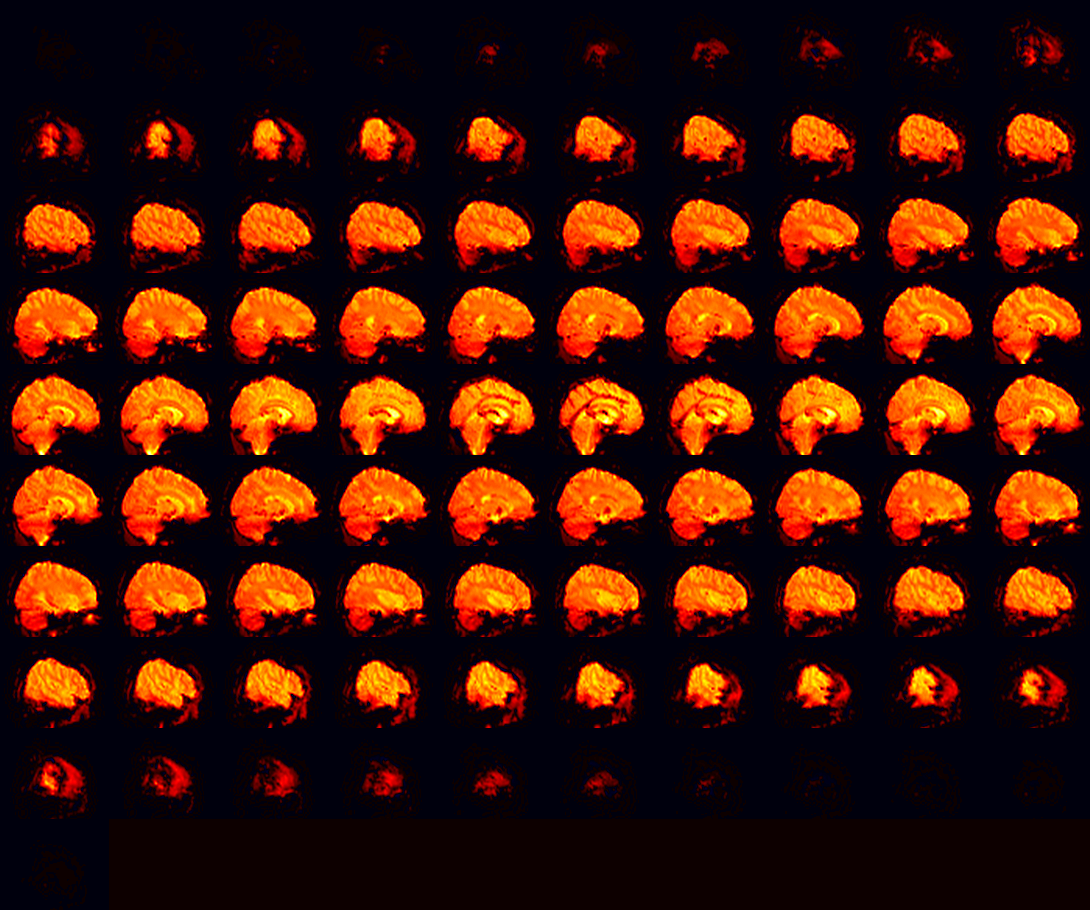

In [6]:
from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_img(fmri_filepaths[0]), threshold=None)

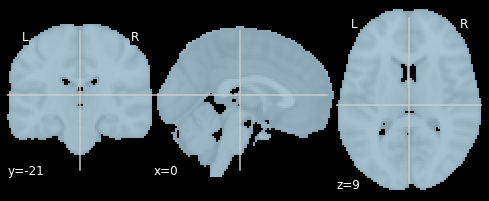

In [7]:
from nilearn.plotting import plot_stat_map, show
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask

template = load_mni152_template()
mask = load_mni152_brain_mask()
# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask, bg_img=template,
                 cmap='Paired')

In [8]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(fmri_filepaths[0])

In [9]:
fmri_masked.shape

(240, 228453)

In [10]:
masker.generate_report()

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,"<class 'nibabel.nifti1.Nifti1Image'> data shape (91, 109, 91) affine: [[ -2. 0. 0. 90.] [ 0. 2. 0. -126.] [ 0. 0. 2. -72.] [ 0. 0. 0. 1.]] metadata: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<' sizeof_hdr : 348 data_type : b'' db_name : b'' extents : 0 session_error : 0 regular : b'' dim_info : 0 dim : [ 3 91 109 91 1 1 1 1] intent_p1 : 0.0 intent_p2 : 0.0 intent_p3 : 0.0 intent_code : none datatype : int64 bitpix : 64 slice_start : 0 pixdim : [-1. 2. 2. 2. 1. 1. 1. 1.] vox_offset : 0.0 scl_slope : nan scl_inter : nan slice_end : 0 slice_code : unknown xyzt_units : 0 cal_max : 0.0 cal_min : 0.0 slice_duration : 0.0 toffset : 0.0 glmax : 0 glmin : 0 descrip : b'' aux_file : b'' qform_code : unknown sform_code : aligned quatern_b : 0.0 quatern_c : 1.0 quatern_d : 0.0 qoffset_x : 90.0 qoffset_y : -126.0 qoffset_z : -72.0 srow_x : [-2. 0. 0. 90.] srow_y : [ 0. 2. 0. -126.] srow_z : [ 0. 0. 2. -72.] intent_name : b'' magic : b'n+1'"
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


The variable "fmri_masked" is a numpy array:



In [11]:
print(fmri_masked)

[[ 0.46438419  0.32480233 -2.39887495 ...  1.03855117  0.79347452
   1.08651653]
 [-0.71080784  1.21396575  0.02692202 ... -0.93993315 -1.08958795
   0.33411081]
 [ 1.57031351  1.83337528  0.20890385 ...  1.34226883  0.43815545
   1.46378394]
 ...
 [-0.87865679 -1.361387   -1.78558291 ... -0.40256922  0.25023042
   0.14218629]
 [-0.23223188 -0.71244091 -0.3800436  ...  0.48092777  0.01464861
  -0.06249364]
 [ 0.95649393  0.13814965  0.80016122 ... -0.47660549 -1.52492451
  -1.16453329]]


In [12]:
print(fmri_masked.shape)

(240, 228453)


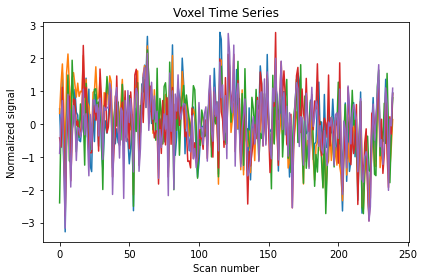

In [13]:
import matplotlib.pyplot as plt
plt.plot(fmri_masked[:, :5])

plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [14]:
import pandas as pd

# Load behavioral information
behavioral = pd.read_table(layout.get(
    subject=layout.get(target='subject', return_type='id')[0],
    return_type='file',
    suffix='events',
    extension='tsv'
    )[0])

# behavioral = pd.concat([pd.read_table(layout.get(
#     subject=layout.get(target='subject', return_type='id')[0],
#     return_type='file',
#     suffix='events',
#     extension='tsv'
#     )[i]) for i in range(3)])
print(behavioral)

    onset  duration  parametric loss  distance from indifference  \
0     0.0         3           0.1273                     -0.0814   
1     4.0         3          -0.0227                     -0.4147   
2     8.0         3           0.1273                      0.2519   
3    18.0         3           0.1773                     -0.0814   
4    24.0         3          -0.3727                     -0.0814   
..    ...       ...              ...                         ...   
81  458.0         3           0.2773                      0.5853   
82  462.0         3          -0.0227                      0.2519   
83  466.0         3          -0.1727                     -0.0814   
84  470.0         3          -0.0227                     -0.4147   
85  474.0         3           0.0773                     -0.0814   

    parametric gain  gain  loss  PTval  respnum  respcat  response_time  
0            -0.139    20    15   5.15        0       -1          0.000  
1            -0.189    18    12   6

In [15]:
# conditions = behavioral[behavioral['respcat'] != -1]['respcat']
conditions = behavioral['respcat']
conditions

0    -1
1     1
2     0
3     1
4     1
     ..
81    0
82    1
83    1
84    1
85    1
Name: respcat, Length: 86, dtype: int64

In [16]:
fmri_masked = fmri_masked[behavioral['onset'].astype(np.int) // 2]
print(fmri_masked.shape)

(86, 228453)


In [17]:
condition_mask = conditions.isin([0, 1])
fmri_masked = fmri_masked[condition_mask]
print(fmri_masked.shape)

(85, 228453)


In [18]:
conditions = conditions[condition_mask]
print(conditions.shape)

(85,)


In [19]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
print(svc)

SVC(kernel='linear')


In [20]:
svc.fit(fmri_masked, conditions)

SVC(kernel='linear')

In [21]:
prediction = svc.predict(fmri_masked)
print(prediction)

[1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 0 1 1 0 1 1 0 1 1 1 1]


In [22]:
print((prediction == conditions).sum() / float(len(conditions)))

1.0


In [24]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
for train, test in cv.split(X=fmri_masked):
    conditions_masked = conditions.values[train]
    svc.fit(fmri_masked[train], conditions_masked)
    prediction = svc.predict(fmri_masked[test])
    print((prediction == conditions.values[test]).sum()
           / float(len(conditions.values[test])))

0.8235294117647058
0.6470588235294118
1.0
0.7647058823529411
0.7647058823529411


In [25]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, conditions)
print(cv_score)

[0.82352941 0.82352941 0.82352941 0.76470588 0.76470588]


In [26]:
coef_ = svc.coef_
print(coef_)

[[-1.21184861e-05 -3.90766902e-06 -1.28214726e-06 ...  2.01724600e-05
  -2.59567241e-05 -2.13936010e-05]]


In [74]:
print(coef_.shape)

(1, 228453)


In [36]:
print(min(coef_[0]), max(coef_[0]), np.mean(coef_[0]))

-0.00013458293365224726 0.00013873545424380586 2.843384574087438e-07


In [126]:
pos_coef = coef_.copy()

In [127]:
coef_img = masker.inverse_transform(pos_coef)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 1)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code  

coef_img is now a NiftiImage.

We can save the coefficients as a nii.gz file:



In [128]:
coef_img.to_filename('mixed_gambles_svc_weights.nii.gz')

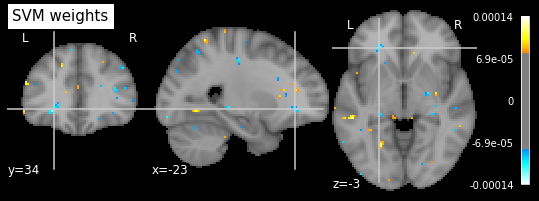

In [138]:
plot_stat_map(coef_img, bg_img=template,
              threshold=8e-05,
              title="SVM weights")

show()

Further reading
----------------

* The `section of the documentation on decoding <decoding>`

* `sphx_glr_auto_examples_02_decoding_plot_haxby_anova_svm.py`
  For decoding without a precomputed mask

* `space_net`

______________

